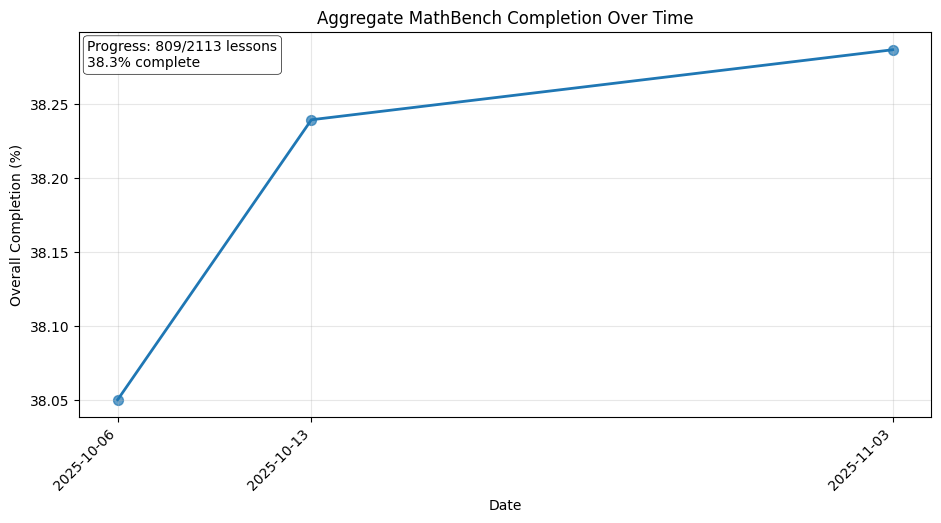

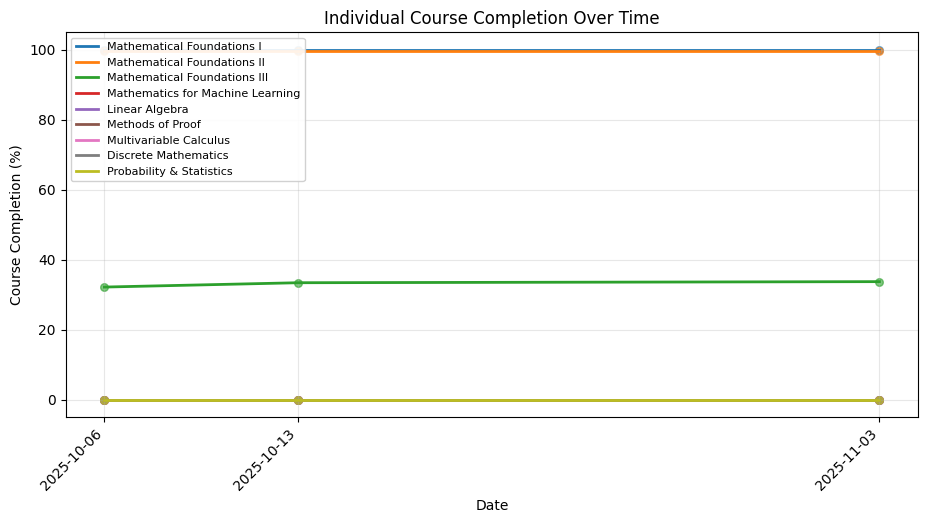

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Load the lesson data
df = pd.read_csv("math_academy_lessons.csv")

# Convert date_completed to datetime
df["date_completed"] = pd.to_datetime(df["date_completed"], errors="coerce")

# Get all completed lessons with dates
completed = df[df["completed"]].copy()

# Get unique dates and sort them
dates = sorted(completed["date_completed"].dropna().unique())

# Calculate cumulative completion for each date
cumulative_data = []
for date in dates:
    # Count how many lessons completed by this date
    completed_by_date = (completed["date_completed"] <= date).sum()
    total_lessons = len(df)
    completion_pct = (completed_by_date / total_lessons) * 100

    cumulative_data.append({
        "date": date,
        "completed": completed_by_date,
        "total": total_lessons,
        "completion_pct": completion_pct,
    })

# Create DataFrame for plotting
scores = pd.DataFrame(cumulative_data).set_index("date")

# Get all courses
courses = df["course"].unique()

# Calculate per-course completion percentages
for course in courses:
    course_total = len(df[df["course"] == course])
    course_completion = []

    for date in dates:
        completed_by_date = len(completed[(completed["course"] == course) &
                                         (completed["date_completed"] <= date)])
        pct = (completed_by_date / course_total) * 100
        course_completion.append(pct)

    scores[course] = course_completion

# Days where any lesson was completed
completed_dates = completed.groupby("date_completed").size()

# Create the figure and plot the aggregate MathBench
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(scores.index, scores["completion_pct"], linewidth=2)

# Mark the session days
ax.scatter(
    scores.index,
    scores["completion_pct"],
    s=50,
    alpha=0.7,
)

# Add a title, labels, and a grid
plt.title("Aggregate MathBench Completion Over Time")
plt.xlabel("Date")
plt.ylabel("Overall Completion (%)")
plt.grid(visible=True, alpha=0.3)

# Group by weeks that START Monday (i.e., weeks END Sunday => "W-SUN")
first_session_each_week = (
    scores.index.to_series()
    .groupby(scores.index.to_period("W-SUN"))
    .min()
    .sort_values()
)

# Use only those dates as x-ticks, rotate 45°
ax.set_xticks(first_session_each_week.tolist())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Get current stats
current_completed = scores["completed"].iloc[-1]
current_total = scores["total"].iloc[-1]
current_pct = scores["completion_pct"].iloc[-1]

# Add current progress to the plot
progress_text = (
    f"Progress: {int(current_completed)}/{int(current_total)} lessons\n"
    f"{current_pct:.1f}% complete"
)
ax.text(
    0.01,
    0.98,
    progress_text,
    transform=ax.transAxes,
    va="top",
    ha="left",
    bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.9, "linewidth": 0.5},
    fontsize=10,
)

# Save the figure
plt.savefig("plots/aggregate_mathbench.png", dpi=1000, bbox_inches="tight")

# Create the figure for individual courses
fig, ax = plt.subplots(figsize=(11, 5))

# Plot each course
for course in courses:
    ax.plot(
        scores.index,
        scores[course],
        label=course,
        linewidth=2,
    )
    ax.scatter(
        scores.index,
        scores[course],
        s=30,
        alpha=0.6,
    )

# Add a title, labels, a grid, and a legend
ax.set_title("Individual Course Completion Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Course Completion (%)")
ax.grid(visible=True, alpha=0.3)
ax.legend(loc="upper left", frameon=True, framealpha=0.9, fontsize=8)

# Group by weeks that START Monday (i.e., weeks END Sunday => "W-SUN")
first_session_each_week = (
    scores.index.to_series()
    .groupby(scores.index.to_period("W-SUN"))
    .min()
    .sort_values()
)

# Use only those dates as x-ticks, rotate 45°
ax.set_xticks(first_session_each_week.tolist())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Save the figure
plt.savefig("plots/individual_mathbench.png", dpi=1000, bbox_inches="tight")